<h2> Web Scraping and Sentiment Analysis Exercise </h2>

Getting the general sentiment on ten reviews of Supergoop's 'PLAY Everyday Lotion SPF 50 with Sunflower Extract' using web scrapping and sentiment analysis.

<h3> IMPORT PACKAGES </h3>

In [84]:
#Import web scrapping packages
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup

#Import sentiment analysis packages
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#Import data manipultion packages
import pandas as pd
import numpy as np

#Import data visualization package
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

<h3> LOAD IN WEBSITE & REVIEWS </h3>

In [ ]:
url = 'https://supergoop.com/products/everyday-sunscreen#wO6jD3l9feVXnFDksoI7sj' 
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get(url)

soup = BeautifulSoup(driver.page_source, 'html.parser')
review_element = soup.find_all('span', class_='ehqzmla3 e12ke1wp6 css-126kb4n e1nqke5h3')
driver.quit()

In [96]:
reviews = [element.text for element in review_element]

reviews

['I buy the biggest size every summer with the pump. We live by the beach band it’s a must have. No one has been sunburned and it’s so easy to put on.',
 'We took it to Cancun in our recent family vacation. The family love it. It is not greasy. So hydrating to the skin. Re-apply every 2 hours. Definitely repurchase this again in our next vacation.',
 'Nice consistency…doesn’t leave a white cast.',
 "I practice yoga outside, swim in an outdoor pool and occasionally, when weather permits, in open water. My skin is also sensitive to manufactured products, so I go as natural as possible while trying to stay as protected as possible. I've tried many, many water-resistant sunblocks and Supergoop!'s Play Everyday one goes on smoothly, with ",
 'I never go out of my house without this on. I love the way it soaks into my skin and I love the SPF coverage. I always have two or three of these on hand.',
 'I buy the biggest size every summer with the pump. We live by the beach band it’s a must have

<h3> INSTANTIATE NLP MODEL </h3>

In [97]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

<h3> ENCODE & DETERMINE SENTIMENT </h3>

In [99]:
tokens = tokenizer.encode('This product is amazing and I would recommend it to everyone.', return_tensors='pt')

tokens

tensor([[  101, 10372, 20058, 10127, 39854, 10110,   151, 11008, 44909, 55667,
         10163, 10197, 10114, 36053,   119,   102]])

In [100]:
tokenizer.decode(tokens[0])

'[CLS] this product is amazing and i would recommend it to everyone. [SEP]'

In [101]:
result = model(tokens)

result

SequenceClassifierOutput(loss=None, logits=tensor([[-2.6862, -2.9182, -0.7802,  1.8384,  3.6056]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [102]:
result.logits

tensor([[-2.6862, -2.9182, -0.7802,  1.8384,  3.6056]],
       grad_fn=<AddmmBackward0>)

In [31]:
int(torch.argmax(result.logits))+1

5

<h3> LOAD REVIEWS INTO DATAFRAME & SCORE </h3>

In [103]:
reviews_df = pd.DataFrame(np.array(reviews), columns=['reviews'])

reviews_df

,reviews
0,I buy the biggest size every summer with the p...
1,We took it to Cancun in our recent family vaca...
2,Nice consistency…doesn’t leave a white cast.
3,"I practice yoga outside, swim in an outdoor po..."
4,I never go out of my house without this on. I ...
5,I buy the biggest size every summer with the p...
6,We took it to Cancun in our recent family vaca...
7,Nice consistency…doesn’t leave a white cast.
8,"I practice yoga outside, swim in an outdoor po..."
9,I never go out of my house without this on. I ...


In [104]:
reviews_df['reviews'][0]

'I buy the biggest size every summer with the pump. We live by the beach band it’s a must have. No one has been sunburned and it’s so easy to put on.'

In [105]:
def sentiment(reviews):
    tokens = tokenizer.encode(reviews, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1
    

In [106]:
sentiment(reviews_df['reviews'][0])

5

In [107]:
reviews_df['sentiment'] = reviews_df['reviews'].apply(lambda x: sentiment(x[:512]))

In [108]:
reviews_df

,reviews,sentiment
0,I buy the biggest size every summer with the p...,5
1,We took it to Cancun in our recent family vaca...,5
2,Nice consistency…doesn’t leave a white cast.,4
3,"I practice yoga outside, swim in an outdoor po...",5
4,I never go out of my house without this on. I ...,5
5,I buy the biggest size every summer with the p...,5
6,We took it to Cancun in our recent family vaca...,5
7,Nice consistency…doesn’t leave a white cast.,4
8,"I practice yoga outside, swim in an outdoor po...",5
9,I never go out of my house without this on. I ...,5


Reviews are scored from 0 to 5, ordinally. 
The number '0' correlates to an extremely negative sentiment while 
the number '5' correlates to an extremely positive sentiment.

In [109]:
sentiment_count = reviews_df.groupby(['sentiment']).count()

sentiment_count

,reviews
sentiment,
4,2
5,8


<AxesSubplot:xlabel='sentiment'>

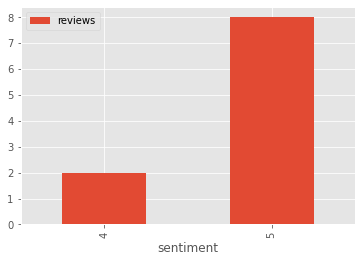

In [110]:
sentiment_count.plot(kind='bar', legend=True)